# Model Training

### Imports

In [10]:
import pandas as pd
import numpy as np
import boto3
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import sagemaker
from sagemaker import PCA, KMeans, get_execution_role, Session
from sklearn.metrics import silhouette_score
import time
from sagemaker.model import Model
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

## Load Training Dataset from S3

In [3]:
train_df = pd.read_csv('s3://team6datasets/splitDatasets/train.csv')

## Sagemaker Session and Role

In [4]:
# Define the SageMaker session and role
sagemaker_session = Session()
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Feature Scaling

In [5]:
# Feature Scaling
scaler  = StandardScaler()

# Convert to float32 for memory efficiency
scaled_data = scaler.fit_transform(train_df.astype('float32'))

## Dimensionality Reduction with Incremental PCA

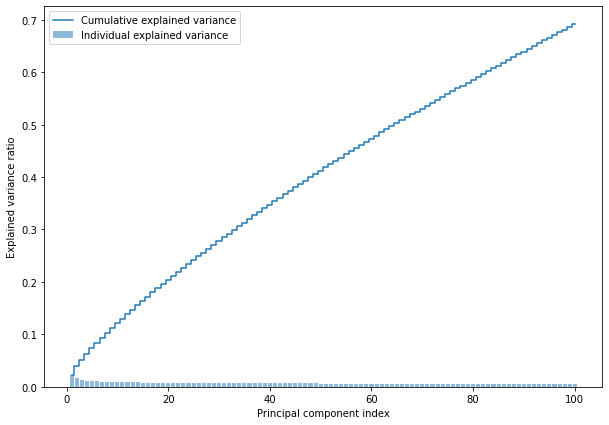

In [6]:
# Use IncrementalPCA for dimensionality reduction
ipca = IncrementalPCA(n_components=100, batch_size=150)
ipca.fit(scaled_data)

# Plot the explained variance ratio
plt.figure(figsize=(10, 7))
plt.bar(range(1, ipca.n_components_ + 1), ipca.explained_variance_ratio_, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, ipca.n_components_ + 1), np.cumsum(ipca.explained_variance_ratio_), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [7]:
# Define PCA model
pca_estimator = PCA(role=get_execution_role(),
                    instance_count = 1,
                    instance_type = 'ml.c4.xlarge',
                    num_components = 10)

# Fit PCA model
pca_estimator.fit(pca_estimator.record_set(scaled_data))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pca-2024-04-03-02-30-03-048


2024-04-03 02:30:03 Starting - Starting the training job...
2024-04-03 02:30:18 Starting - Preparing the instances for training...
2024-04-03 02:30:59 Downloading - Downloading input data......
2024-04-03 02:31:37 Downloading - Downloading the training image......
2024-04-03 02:32:53 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[04/03/2024 02:33:06 INFO 139777819453248] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[04/03/2024 02:33:

## Model Training with KMeans Algorithm

In [17]:
# Define hyperparameters for KMeans models
hyperparameter_sets = [
    {'k': 5, 'init_method': 'random'},
    {'k': 10, 'init_method': 'random'},
    {'k': 15, 'init_method': 'random'},
    {'k': 20, 'init_method': 'random'}
]

# Initialize S3 client
s3 = boto3.client('s3')

# Run trials for KMeans models
role = get_execution_role()

# Check if the output path exists, create it if it doesn't
output_path = 's3://team6datasets/kmeans_model_output/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

for hyperparameters in hyperparameter_sets:
    k_value = hyperparameters['k']
    model_output_path = f's3://team6datasets/kmeans_model_output/kmeans-{k_value}/output/'
    
    # Check if the model output path exists in S3
    try:
        s3.head_object(Bucket='team6datasets', Key=f'kmeans_model_output/kmeans-{k_value}/output/model.tar.gz')
        print(f"Model for k={k_value} already trained.")
    except Exception as e:
        print(f"Model for k={k_value} not trained yet. Training now...")
        
        # Train the model
        kmeans = KMeans(role=role,
                        instance_count=1,
                        instance_type='ml.c4.xlarge',
                        k=k_value,
                        output_path=output_path)
        
        # Fit the model
        kmeans.fit(kmeans.record_set(scaled_data), job_name=f"kmeans-{k_value}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Model for k=5 already trained.
Model for k=10 already trained.
Model for k=15 already trained.
Model for k=20 already trained.


## Calculate Silhouette Scores for KMeans Models

### List objects in S3 folder for KMeans

In [32]:
# Initialize S3 client
s3 = boto3.client('s3')

# Bucket name
bucket_name = 'team6datasets'

# Prefix
prefix = 'kmeans_model_output/'

# List objects in the bucket with the given prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Extract folder names from the object keys
folders = []

if 'Contents' in response:
    for obj in response['Contents']:
        key = obj['Key']
        folder_name = key.split('/')[1]
        if folder_name not in folders:
            folders.append(folder_name)

print("Folders found:", folders)

Folders found: ['kmeans-10', 'kmeans-15', 'kmeans-20', 'kmeans-5']


In [26]:
# Calculate Silhouette Scores for KMeans Models
def calculate_silhouette_score(model_data, hyperparameters):
    # Define the SageMaker model
    model = Model(
        model_data=model_data,
        image_uri=sagemaker.image_uris.retrieve("kmeans", region),
        role=role,
        sagemaker_session=sagemaker_session
    )
    
    # Deploy the model
    predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
    
    # Set serializer and deserializer
    predictor.serializer = CSVSerializer()
    predictor.deserializer = JSONDeserializer()
    
    # Make predictions
    results = predictor.predict(scaled_data.tolist())
    cluster_labels = np.array([r['closest_cluster'] for r in results['predictions']])
    
    # Calculate Silhouette Score
    score = silhouette_score(scaled_data, cluster_labels)
    
    # Delete the endpoint
    predictor.delete_endpoint()
    
    return score

# Get model artifacts and hyperparameters
model_artifacts = [
    {
        "model_data": f"s3://{bucket_name}/kmeans_model_output/kmeans-{hyperparameters['k']}/output/model.tar.gz",
        "hyperparameters": hyperparameters
    }
    for hyperparameters in hyperparameter_sets
]

print("Model artifacts:", model_artifacts)  # Debug statement

# Calculate silhouette scores
silhouette_scores = [calculate_silhouette_score(model['model_data'], model['hyperparameters']) for model in model_artifacts]

print("Silhouette scores:", silhouette_scores)

Model artifacts: [{'model_data': 's3://team6datasets/kmeans_model_output/kmeans-5/output/model.tar.gz', 'hyperparameters': {'k': 5, 'init_method': 'random'}}, {'model_data': 's3://team6datasets/kmeans_model_output/kmeans-10/output/model.tar.gz', 'hyperparameters': {'k': 10, 'init_method': 'random'}}, {'model_data': 's3://team6datasets/kmeans_model_output/kmeans-15/output/model.tar.gz', 'hyperparameters': {'k': 15, 'init_method': 'random'}}, {'model_data': 's3://team6datasets/kmeans_model_output/kmeans-20/output/model.tar.gz', 'hyperparameters': {'k': 20, 'init_method': 'random'}}]


NameError: name 'region' is not defined